In [18]:
import pyedflib
import pandas as pd

Concatinating signals for training


Note for training only signals recorded during mental arithmetic will be used

In [21]:
import pyedflib
import numpy as np
import pandas as pd
import os

# Path to the EDF files and the CSV file
edf_folder_path = '/Users/ritwikghosh/Downloads/IIT Roorkee Project/eeg-during-mental-arithmetic-tasks-1.0.0/'
csv_file_path = os.path.join(edf_folder_path, 'subject-info.csv')

# Read the CSV file
subject_info = pd.read_csv(csv_file_path)

# Initialize the X matrix and y array
num_trials = 36
num_channels = 19
num_samples = 31000

X = np.zeros((num_trials, num_channels, num_samples))
y = np.zeros(num_trials)

# Process each subject and their trials
trial_index = 0
for i in range(1,36):
    subject_name = f'Subject{i:02d}'
    print(subject_name)
    label = subject_info[subject_info['Subject'] == subject_name]['Count quality'].values[0]
    
    for trial in range(2, 3):
        edf_file_name = f'{subject_name}_{trial}.edf'
        edf_file_path = os.path.join(edf_folder_path, edf_file_name)
        
        # Open the EDF file
        data = pyedflib.EdfReader(edf_file_path)
        
        # Read the signals data and convert to array
        signal_data = np.zeros((data.signals_in_file, data.getNSamples()[0]))
        for j in range(data.signals_in_file):
            signal_data[j, :] = data.readSignal(j)
        
        # Close the EDF file
        data.close()
        
        # Select only the first 19 channels and the first 91000 samples
        X[trial_index, :, :] = signal_data[:19, :num_samples]
        y[trial_index] = label
        
        trial_index += 1

# Verify the shape of X and y
print(X.shape)  # Should be (36, 19, 91000)
print(y.shape)  # Should be (36,)
print(y)        # Verify the labels


Subject01
Subject02
Subject03
Subject04
Subject05
Subject06
Subject07
Subject08
Subject09
Subject10
Subject11
Subject12
Subject13
Subject14
Subject15
Subject16
Subject17
Subject18
Subject19
Subject20
Subject21
Subject22
Subject23
Subject24
Subject25
Subject26
Subject27
Subject28
Subject29
Subject30
Subject31
Subject32
Subject33
Subject34
Subject35
(36, 19, 31000)
(36,)
[1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


In [22]:
y.sum() #data imbalance

26.0

EEGNET

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 19, Samples = 31000, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)



In [24]:
model = EEGNet(nb_classes=2, Chans=19, Samples=31000, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 19, 31000, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 31000, 8)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 31000, 8)   │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 1, 31000, 16)   │           304 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 31000, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1, 31000, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 7750, 16)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 7750, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 1, 7750, 16)    │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 7750, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 7750, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 968, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 968, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        30,978 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,466 (126.82 KB)

 Trainable params: 32,386 (126.51 KB)

 Non-trainable params: 80 (320.00 B)

# Reshaping into desired input shape

In [26]:
X = X[:, :, :, np.newaxis]

# Encoding Label Y as categorical_crossentropy loss takes labels in multiple columns

In [27]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def encode_labels(y):
    # Convert y to integers
    y = np.round(y).astype('int')

    # Create a dictionary to map int labels to integer labels in ascending order
    label_dict = {label: i for i, label in enumerate(sorted(np.unique(y)))}

    # Map integer labels to integer labels in ascending order
    y_mapped = np.array([label_dict[label] for label in y]).reshape(-1, 1)

    # One-hot encode y
    onehot_encoder = OneHotEncoder()
    y_encoded = onehot_encoder.fit_transform(y_mapped)

    # Convert the one-hot encoded array into a DataFrame
    y_df = pd.DataFrame(y_encoded.toarray(), columns=[f'label_{i}' for i in range(y_encoded.shape[1])])

    return y_df

# Example usage:
# Assuming you have y defined earlier
# y_df = encode_labels(y)

In [28]:
X.shape

(36, 19, 31000, 1)

# Stratified Splitting due to imbalance

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=0, stratify=y_train)


In [30]:
y_train= encode_labels(y_train)
y_test= encode_labels(y_test)
y_val= encode_labels(y_val)

In [60]:
y_train.head()

,label_0,label_1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

In [59]:
# Model training for only 5 EPOCHS due its tendency to overfit as we have only 36 trails

In [32]:
fittedModel=model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=2, 
                        validation_data=(X_val, y_val))

Epoch 1/5
1/1 - 6s - 6s/step - accuracy: 0.6400 - loss: 0.6263 - val_accuracy: 0.6667 - val_loss: 0.6013
Epoch 2/5
1/1 - 6s - 6s/step - accuracy: 0.7200 - loss: 0.5524 - val_accuracy: 0.6667 - val_loss: 0.3759
Epoch 3/5
1/1 - 5s - 5s/step - accuracy: 0.7200 - loss: 0.4032 - val_accuracy: 1.0000 - val_loss: 0.3446
Epoch 4/5
1/1 - 5s - 5s/step - accuracy: 0.8000 - loss: 0.2789 - val_accuracy: 1.0000 - val_loss: 0.3447
Epoch 5/5
1/1 - 5s - 5s/step - accuracy: 0.9600 - loss: 0.1501 - val_accuracy: 1.0000 - val_loss: 0.3568


In [52]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_labels)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Accuracy on the test set: 75.00%


In [34]:
model1 = EEGNet(nb_classes=2, Chans=19, Samples=31000, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [35]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['f1_score'])

In [36]:
fittedModel=model1.fit(X_train, y_train, batch_size=64, epochs=5, verbose=2, 
                        validation_data=(X_val, y_val))

Epoch 1/5
1/1 - 6s - 6s/step - f1_score: 0.4792 - loss: 1.0890 - val_f1_score: 0.4000 - val_loss: 0.6007
Epoch 2/5
1/1 - 5s - 5s/step - f1_score: 0.7500 - loss: 0.5563 - val_f1_score: 1.0000 - val_loss: 0.4661
Epoch 3/5
1/1 - 5s - 5s/step - f1_score: 0.5536 - loss: 0.2982 - val_f1_score: 1.0000 - val_loss: 0.4297
Epoch 4/5
1/1 - 5s - 5s/step - f1_score: 1.0000 - loss: 0.1677 - val_f1_score: 1.0000 - val_loss: 0.4196
Epoch 5/5
1/1 - 5s - 5s/step - f1_score: 1.0000 - loss: 0.0834 - val_f1_score: 1.0000 - val_loss: 0.4206


In [54]:
from sklearn.metrics import f1_score
y_pred = model1.predict(X_test)

y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate the accuracy score
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"F1_score on the test set: {f1 * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
F1_score on the test set: 57.69%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Best Threshold: 0.18
Best F1 Score: 75.40%


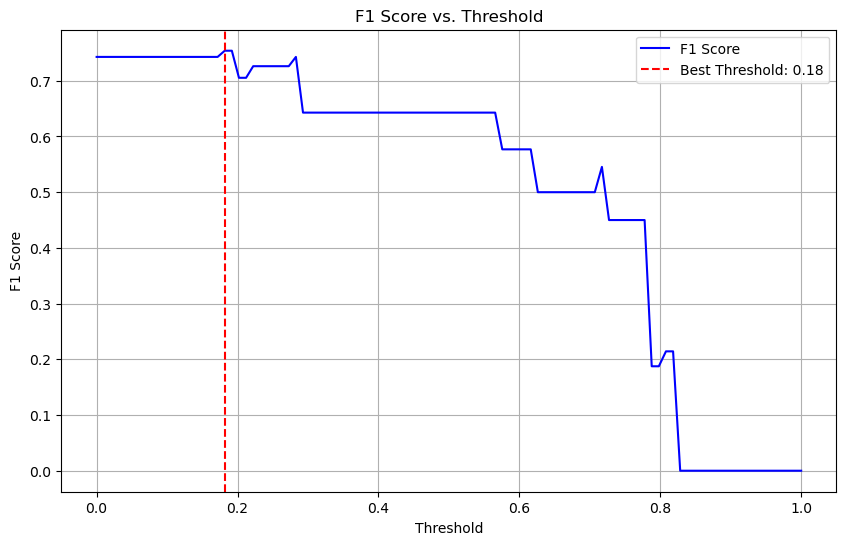

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Generate predictions
y_pred = model.predict(X_test)

# Initialize lists to store thresholds and corresponding F1 scores
thresholds = np.linspace(0, 1, 100)
f1_scores = []

# Variables to track the best threshold and F1 score
best_threshold = 0
best_f1_score = 0

# Calculate F1 score for each threshold
for threshold in thresholds:
    y_pred_labels = (y_pred > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    f1_scores.append(f1)
    
    # Update best threshold and F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

# Print the best threshold and F1 score
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score * 100:.2f}%")

# Plot the F1 score against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='b')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()
